Parámetros ajustados:
Gaussiana 1: Amplitud = -1.463, Media = 508.219, Sigma = 54.311
Gaussiana 2: Amplitud = -0.935, Media = 574.855, Sigma = 13.612


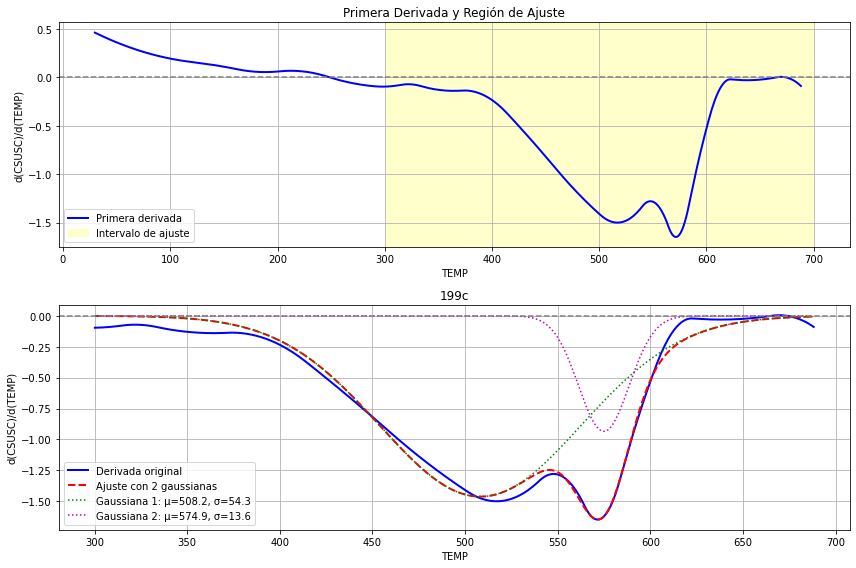


Ajuste con parámetros controlados:
Gaussiana 1: A=-1.463, μ=508.219 (inicial=400), σ=-54.311 (inicial=30)
Gaussiana 2: A=-0.935, μ=574.855 (inicial=550), σ=13.612 (inicial=40)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('199c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Suavizado y cálculo de la primera derivada
smoothing_param = 22  # Ajustar según necesidad
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear una malla más fina para el ajuste
fine_temp = np.linspace(min(temp), max(temp), 500)
fine_derivative = derivative(fine_temp)

# 2. Definición de funciones gaussianas
def gaussian(x, amp, mu, sigma):
    """Función gaussiana individual"""
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    """Combinación de dos gaussianas"""
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2))

# 3. Seleccionar solo los datos en el intervalo [300, 700]
mask = (fine_temp >= 300) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

# 4. Estimación inicial de parámetros (ajustar según tus necesidades)
# Formato: [amp1, mu1, sigma1, amp2, mu2, sigma2]
initial_guess = [
    -0.99, 400, 30,   # Primera gaussiana (negativa)
    0.7, 550, 40     # Segunda gaussiana (positiva)
]

# 5. Ajuste de la curva con dos gaussianas
popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)

# Extraer parámetros ajustados
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

print("Parámetros ajustados:")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media = {mu1:.3f}, Sigma = {sigma1:.3f}")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media = {mu2:.3f}, Sigma = {sigma2:.3f}")

# 6. Visualización
plt.figure(figsize=(12, 8))

# Gráfico completo de la derivada
plt.subplot(2, 1, 1)
plt.plot(fine_temp, fine_derivative, 'b-', label='Primera derivada', linewidth=2)
plt.axvspan(300, 700, color='yellow', alpha=0.2, label='Intervalo de ajuste')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('Primera Derivada y Región de Ajuste')
plt.legend()
plt.grid(True)

# Gráfico detallado del ajuste en el intervalo [300, 700]
plt.subplot(2, 1, 2)
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
# Componentes individuales
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('199c')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Función para ajuste con parámetros controlados
def controlled_gaussian_fit(x_data, y_data, 
                          mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess,
                          amp1_guess=None, amp2_guess=None):
    """
    Ajuste con dos gaussianas controlando medias y desviaciones estándar
    
    Parámetros:
    x_data, y_data: datos a ajustar
    mu1_guess, sigma1_guess: media y sigma inicial para gaussiana 1
    mu2_guess, sigma2_guess: media y sigma inicial para gaussiana 2
    amp1_guess, amp2_guess: amplitudes iniciales (opcional)
    """
    # Estimar amplitudes si no se proporcionan
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    # Realizar el ajuste
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    
    return popt

# Ejemplo de uso con control de medias y sigmas:
if __name__ == "__main__":
    # Define los parámetros de control aquí
    my_mu1 = 400    # Media deseada para la primera gaussiana
    my_sigma1 = 30   # Sigma deseada para la primera gaussiana
    my_mu2 = 550     # Media deseada para la segunda gaussiana
    my_sigma2 = 40   # Sigma deseada para la segunda gaussiana
    
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=my_mu1, sigma1_guess=my_sigma1,
                                       mu2_guess=my_mu2, sigma2_guess=my_sigma2)
    
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    print("\nAjuste con parámetros controlados:")
    print(f"Gaussiana 1: A={amp1:.3f}, μ={mu1:.3f} (inicial={my_mu1}), σ={sigma1:.3f} (inicial={my_sigma1})")
    print(f"Gaussiana 2: A={amp2:.3f}, μ={mu2:.3f} (inicial={my_mu2}), σ={sigma2:.3f} (inicial={my_sigma2})")
    

Parámetros ajustados:
Gaussiana 1: Amplitud = -1.051, Media = 500.731, Sigma = 75.442
Gaussiana 2: Amplitud = -1.174, Media = 594.941, Sigma = -21.846


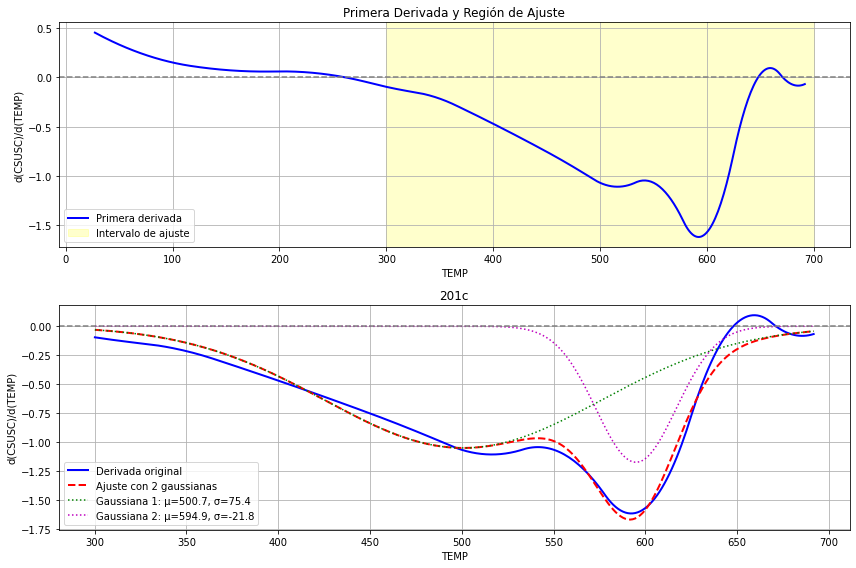


Ajuste con parámetros controlados:
Gaussiana 1: A=-1.051, μ=500.731 (inicial=400), σ=-75.442 (inicial=30)
Gaussiana 2: A=-1.174, μ=594.941 (inicial=550), σ=21.846 (inicial=40)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('201c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Suavizado y cálculo de la primera derivada
smoothing_param = 35  # Ajustar según necesidad
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear una malla más fina para el ajuste
fine_temp = np.linspace(min(temp), max(temp), 500)
fine_derivative = derivative(fine_temp)

# 2. Definición de funciones gaussianas
def gaussian(x, amp, mu, sigma):
    """Función gaussiana individual"""
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    """Combinación de dos gaussianas"""
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2))

# 3. Seleccionar solo los datos en el intervalo [300, 700]
mask = (fine_temp >= 300) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

# 4. Estimación inicial de parámetros (ajustar según tus necesidades)
# Formato: [amp1, mu1, sigma1, amp2, mu2, sigma2]
initial_guess = [
    -0.99, 400, 30,   # Primera gaussiana (negativa)
    0.7, 550, 40     # Segunda gaussiana (positiva)
]

# 5. Ajuste de la curva con dos gaussianas
popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)

# Extraer parámetros ajustados
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

print("Parámetros ajustados:")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media = {mu1:.3f}, Sigma = {sigma1:.3f}")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media = {mu2:.3f}, Sigma = {sigma2:.3f}")

# 6. Visualización
plt.figure(figsize=(12, 8))

# Gráfico completo de la derivada
plt.subplot(2, 1, 1)
plt.plot(fine_temp, fine_derivative, 'b-', label='Primera derivada', linewidth=2)
plt.axvspan(300, 700, color='yellow', alpha=0.2, label='Intervalo de ajuste')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('Primera Derivada y Región de Ajuste')
plt.legend()
plt.grid(True)

# Gráfico detallado del ajuste en el intervalo [300, 700]
plt.subplot(2, 1, 2)
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
# Componentes individuales
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('201c')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Función para ajuste con parámetros controlados
def controlled_gaussian_fit(x_data, y_data, 
                          mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess,
                          amp1_guess=None, amp2_guess=None):
    """
    Ajuste con dos gaussianas controlando medias y desviaciones estándar
    
    Parámetros:
    x_data, y_data: datos a ajustar
    mu1_guess, sigma1_guess: media y sigma inicial para gaussiana 1
    mu2_guess, sigma2_guess: media y sigma inicial para gaussiana 2
    amp1_guess, amp2_guess: amplitudes iniciales (opcional)
    """
    # Estimar amplitudes si no se proporcionan
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    # Realizar el ajuste
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    
    return popt

# Ejemplo de uso con control de medias y sigmas:
if __name__ == "__main__":
    # Define los parámetros de control aquí
    my_mu1 = 400    # Media deseada para la primera gaussiana
    my_sigma1 = 30   # Sigma deseada para la primera gaussiana
    my_mu2 = 550     # Media deseada para la segunda gaussiana
    my_sigma2 = 40   # Sigma deseada para la segunda gaussiana
    
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=my_mu1, sigma1_guess=my_sigma1,
                                       mu2_guess=my_mu2, sigma2_guess=my_sigma2)
    
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    print("\nAjuste con parámetros controlados:")
    print(f"Gaussiana 1: A={amp1:.3f}, μ={mu1:.3f} (inicial={my_mu1}), σ={sigma1:.3f} (inicial={my_sigma1})")
    print(f"Gaussiana 2: A={amp2:.3f}, μ={mu2:.3f} (inicial={my_mu2}), σ={sigma2:.3f} (inicial={my_sigma2})")
    

Parámetros ajustados:
Gaussiana 1: Amplitud = -0.378, Media = 228.594, Sigma = 80.708
Gaussiana 2: Amplitud = -0.080, Media = 483.406, Sigma = 84.462


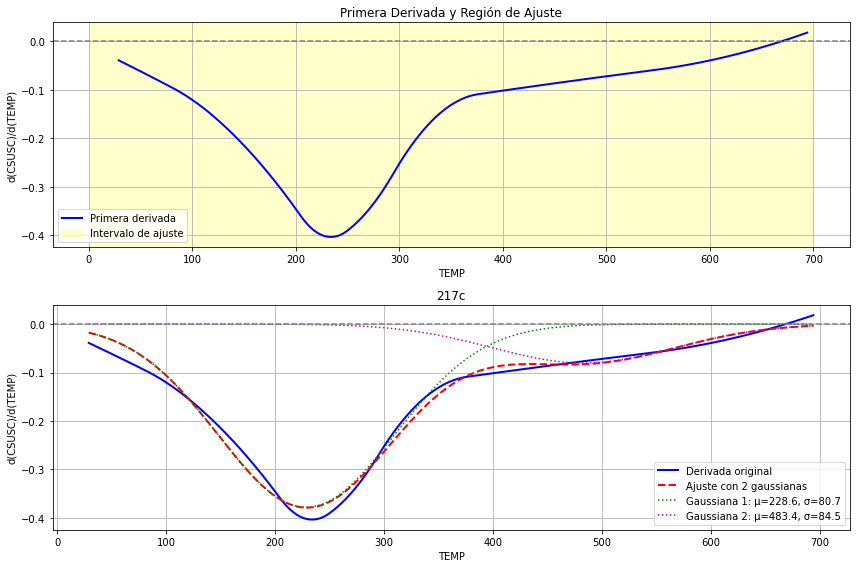


Ajuste con parámetros controlados:
Gaussiana 1: A=-0.378, μ=228.594 (inicial=400), σ=80.708 (inicial=30)
Gaussiana 2: A=-0.080, μ=483.407 (inicial=550), σ=84.462 (inicial=40)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('217c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Suavizado y cálculo de la primera derivada
smoothing_param = 35  # Ajustar según necesidad
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear una malla más fina para el ajuste
fine_temp = np.linspace(min(temp), max(temp), 500)
fine_derivative = derivative(fine_temp)

# 2. Definición de funciones gaussianas
def gaussian(x, amp, mu, sigma):
    """Función gaussiana individual"""
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    """Combinación de dos gaussianas"""
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2))

# 3. Seleccionar solo los datos en el intervalo [300, 700]
mask = (fine_temp >= 0) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

# 4. Estimación inicial de parámetros (ajustar según tus necesidades)
# Formato: [amp1, mu1, sigma1, amp2, mu2, sigma2]
initial_guess = [
    -0.99, 400, 30,   # Primera gaussiana (negativa)
    0.7, 550, 40     # Segunda gaussiana (positiva)
]

# 5. Ajuste de la curva con dos gaussianas
popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)

# Extraer parámetros ajustados
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

print("Parámetros ajustados:")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media = {mu1:.3f}, Sigma = {sigma1:.3f}")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media = {mu2:.3f}, Sigma = {sigma2:.3f}")

# 6. Visualización
plt.figure(figsize=(12, 8))

# Gráfico completo de la derivada
plt.subplot(2, 1, 1)
plt.plot(fine_temp, fine_derivative, 'b-', label='Primera derivada', linewidth=2)
plt.axvspan(0, 700, color='yellow', alpha=0.2, label='Intervalo de ajuste')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('Primera Derivada y Región de Ajuste')
plt.legend()
plt.grid(True)

# Gráfico detallado del ajuste en el intervalo [300, 700]
plt.subplot(2, 1, 2)
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
# Componentes individuales
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP')
plt.ylabel('d(CSUSC)/d(TEMP)')
plt.title('217c')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Función para ajuste con parámetros controlados
def controlled_gaussian_fit(x_data, y_data, 
                          mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess,
                          amp1_guess=None, amp2_guess=None):
    """
    Ajuste con dos gaussianas controlando medias y desviaciones estándar
    
    Parámetros:
    x_data, y_data: datos a ajustar
    mu1_guess, sigma1_guess: media y sigma inicial para gaussiana 1
    mu2_guess, sigma2_guess: media y sigma inicial para gaussiana 2
    amp1_guess, amp2_guess: amplitudes iniciales (opcional)
    """
    # Estimar amplitudes si no se proporcionan
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    # Realizar el ajuste
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    
    return popt

# Ejemplo de uso con control de medias y sigmas:
if __name__ == "__main__":
    # Define los parámetros de control aquí
    my_mu1 = 400    # Media deseada para la primera gaussiana
    my_sigma1 = 30   # Sigma deseada para la primera gaussiana
    my_mu2 = 550     # Media deseada para la segunda gaussiana
    my_sigma2 = 40   # Sigma deseada para la segunda gaussiana
    
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=my_mu1, sigma1_guess=my_sigma1,
                                       mu2_guess=my_mu2, sigma2_guess=my_sigma2)
    
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    print("\nAjuste con parámetros controlados:")
    print(f"Gaussiana 1: A={amp1:.3f}, μ={mu1:.3f} (inicial={my_mu1}), σ={sigma1:.3f} (inicial={my_sigma1})")
    print(f"Gaussiana 2: A={amp2:.3f}, μ={mu2:.3f} (inicial={my_mu2}), σ={sigma2:.3f} (inicial={my_sigma2})")
    

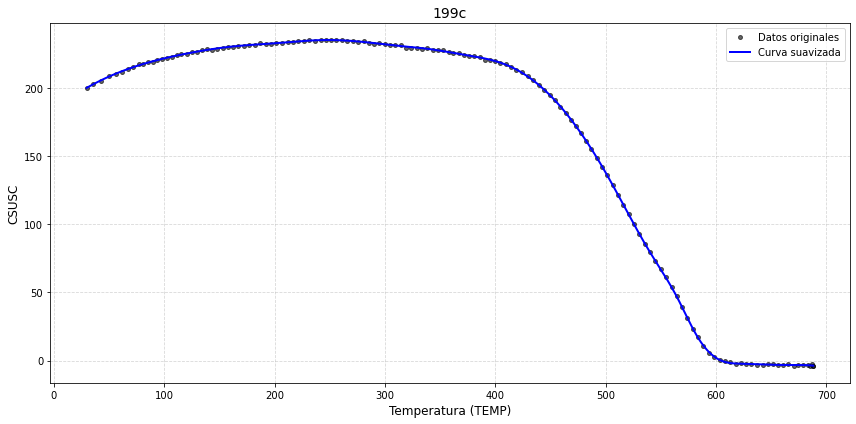

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Cargar datos
data = np.loadtxt('199c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Aplicar suavizado con spline cúbico
smoothing_param = 22  # Puedes ajustar este valor (mayor = más suave)
spline = UnivariateSpline(temp, csusc, s=smoothing_param)

# Crear una malla fina para evaluación
fine_temp = np.linspace(min(temp), max(temp), 1000)
fine_csusc = spline(fine_temp)

# 2. Configuración de la figura
plt.figure(figsize=(12, 6))

# Graficar datos originales y suavizado
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')

# Etiquetas y título
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('199c', fontsize=14)

# Elementos adicionales
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Ajustar márgenes
plt.tight_layout()

# Mostrar figura
plt.show()

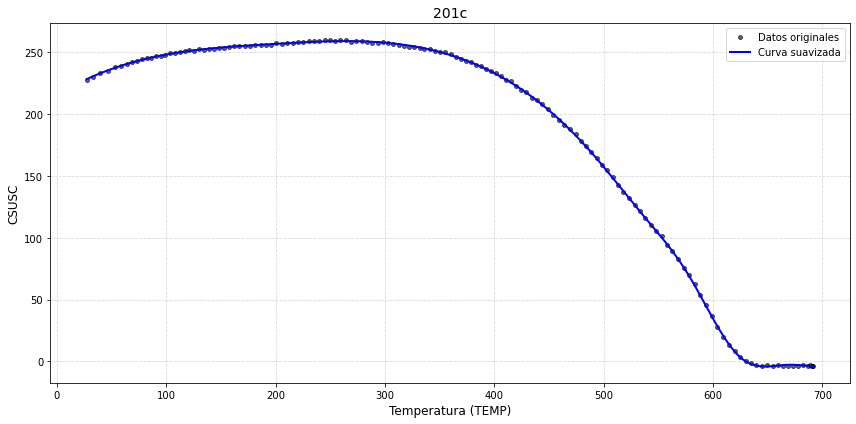

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Cargar datos
data = np.loadtxt('201c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Aplicar suavizado con spline cúbico
smoothing_param = 40  # Puedes ajustar este valor (mayor = más suave)
spline = UnivariateSpline(temp, csusc, s=smoothing_param)

# Crear una malla fina para evaluación
fine_temp = np.linspace(min(temp), max(temp), 1000)
fine_csusc = spline(fine_temp)

# 2. Configuración de la figura
plt.figure(figsize=(12, 6))

# Graficar datos originales y suavizado
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')

# Etiquetas y título
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('201c', fontsize=14)

# Elementos adicionales
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Ajustar márgenes
plt.tight_layout()

# Mostrar figura
plt.show()

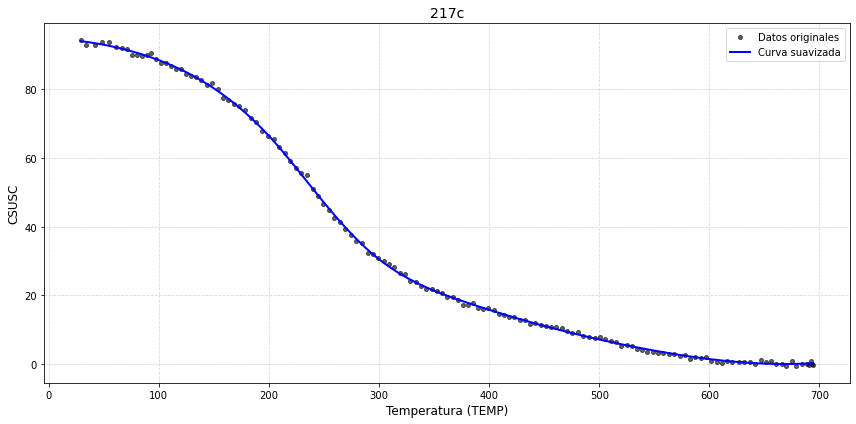

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Cargar datos
data = np.loadtxt('217c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# 1. Aplicar suavizado con spline cúbico
smoothing_param = 35  # Puedes ajustar este valor (mayor = más suave)
spline = UnivariateSpline(temp, csusc, s=smoothing_param)

# Crear una malla fina para evaluación
fine_temp = np.linspace(min(temp), max(temp), 1000)
fine_csusc = spline(fine_temp)

# 2. Configuración de la figura
plt.figure(figsize=(12, 6))

# Graficar datos originales y suavizado
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')

# Etiquetas y título
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('217c', fontsize=14)

# Elementos adicionales
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

# Ajustar márgenes
plt.tight_layout()

# Mostrar figura
plt.show()

AQUI SON LAS BUENAS

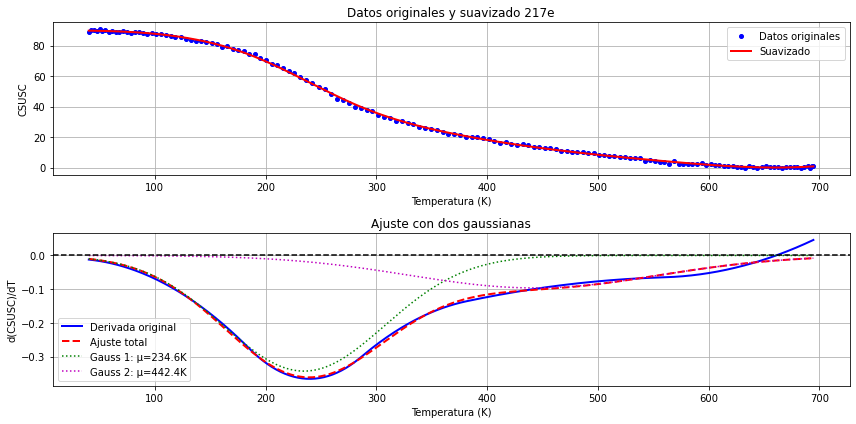


=== Resultados del análisis ===
Gaussiana 1: Amplitud = -0.343, Media μ = 234.6 K, Desviación estándar σ = 72.9 K
Gaussiana 2: Amplitud = -0.096, Media μ = 442.4 K, Desviación estándar σ = 113.2 K


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# =============================================
# 0. Carga y preparación de datos
# =============================================
try:
    data = np.loadtxt('217e.txt', skiprows=1)
    temp = data[:, 0]
    csusc = data[:, 1]
    
    # Ordenar los datos por temperatura
    sort_idx = np.argsort(temp)
    temp_sorted = temp[sort_idx]
    csusc_sorted = csusc[sort_idx]
    
except Exception as e:
    raise ValueError(f"Error al cargar/ordenar datos: {str(e)}")

# =============================================
# 1. Suavizado y cálculo de derivadas
# =============================================
smoothing_param = 50
spline = UnivariateSpline(temp_sorted, csusc_sorted, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear malla fina
fine_temp = np.linspace(min(temp_sorted), max(temp_sorted), 500)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Definición de funciones gaussianas
# =============================================
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2))

# =============================================
# 3. Ajuste con dos gaussianas (300-700K)
# =============================================
mask = (fine_temp >= 0) & (fine_temp <= 7000)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

initial_guess = [-0.5, 400, 30, 0.3, 550, 40]

try:
    popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = popt
except RuntimeError:
    alt_guess = [-0.3, 420, 25, 0.2, 580, 35]
    popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=alt_guess)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

# =============================================
# 4. Visualización (solo gráficos 1 y 3)
# =============================================
plt.figure(figsize=(12, 6))

# Gráfico 1: Datos originales y suavizado
plt.subplot(2, 1, 1)
plt.plot(temp_sorted, csusc_sorted, 'bo', markersize=4, label='Datos originales')
plt.plot(fine_temp, fine_csusc, 'r-', label='Suavizado', linewidth=2)
plt.xlabel('Temperatura (K)')
plt.ylabel('CSUSC')
plt.title('Datos originales y suavizado 217e')
plt.legend()
plt.grid(True)

# Gráfico 3: Ajuste con gaussianas
plt.subplot(2, 1,2 )
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', label='Ajuste total', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gauss 1: μ={mu1:.1f}K', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gauss 2: μ={mu2:.1f}K', linewidth=1.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Temperatura (K)')
plt.ylabel('d(CSUSC)/dT')
plt.title('Ajuste con dos gaussianas')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 5. Resultados numéricos
# =============================================
print("\n=== Resultados del análisis ===")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.1f} K, Desviación estándar σ = {sigma1:.1f} K")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.1f} K, Desviación estándar σ = {sigma2:.1f} K")

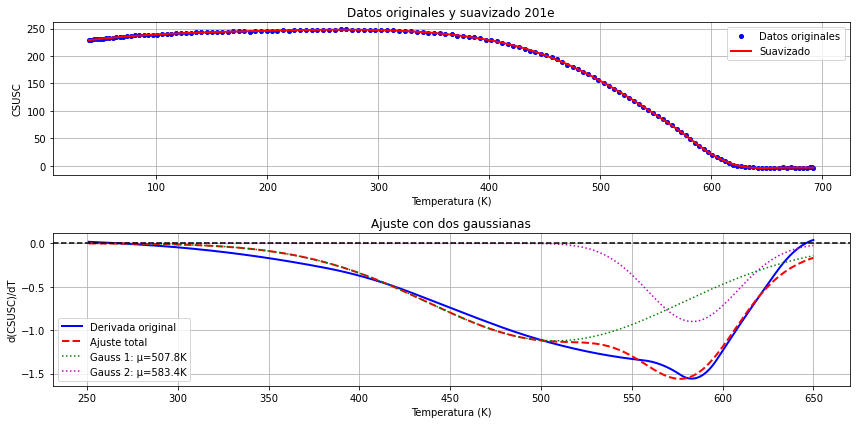


=== Resultados del análisis ===
Gaussiana 1: Amplitud = -1.123, Media μ = 507.8 K, Desviación estándar σ = 70.1 K
Gaussiana 2: Amplitud = -0.901, Media μ = 583.4 K, Desviación estándar σ = -24.7 K


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# =============================================
# 0. Carga y preparación de datos
# =============================================
try:
    data = np.loadtxt('201e.txt', skiprows=1)
    temp = data[:, 0]
    csusc = data[:, 1]
    
    # Ordenar los datos por temperatura
    sort_idx = np.argsort(temp)
    temp_sorted = temp[sort_idx]
    csusc_sorted = csusc[sort_idx]
    
except Exception as e:
    raise ValueError(f"Error al cargar/ordenar datos: {str(e)}")

# =============================================
# 1. Suavizado y cálculo de derivadas
# =============================================
smoothing_param = 35
spline = UnivariateSpline(temp_sorted, csusc_sorted, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear malla fina
fine_temp = np.linspace(min(temp_sorted), max(temp_sorted), 500)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Definición de funciones gaussianas
# =============================================
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2))

# =============================================
# 3. Ajuste con dos gaussianas (300-700K)
# =============================================
mask = (fine_temp >= 250) & (fine_temp <= 650)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

initial_guess = [-0.5, 400, 30, 0.3, 550, 40]

try:
    popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = popt
except RuntimeError:
    alt_guess = [-0.3, 420, 25, 0.2, 580, 35]
    popt, pcov = curve_fit(double_gaussian, x_fit, y_fit, p0=alt_guess)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

# =============================================
# 4. Visualización (solo gráficos 1 y 3)
# =============================================
plt.figure(figsize=(12, 6))

# Gráfico 1: Datos originales y suavizado
plt.subplot(2, 1, 1)
plt.plot(temp_sorted, csusc_sorted, 'bo', markersize=4, label='Datos originales')
plt.plot(fine_temp, fine_csusc, 'r-', label='Suavizado', linewidth=2)
plt.xlabel('Temperatura (K)')
plt.ylabel('CSUSC')
plt.title('Datos originales y suavizado 201e')
plt.legend()
plt.grid(True)

# Gráfico 3: Ajuste con gaussianas
plt.subplot(2, 1, 2)
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', label='Ajuste total', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gauss 1: μ={mu1:.1f}K', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gauss 2: μ={mu2:.1f}K', linewidth=1.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Temperatura (K)')
plt.ylabel('d(CSUSC)/dT')
plt.title('Ajuste con dos gaussianas')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 5. Resultados numéricos
# =============================================
print("\n=== Resultados del análisis ===")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.1f} K, Desviación estándar σ = {sigma1:.1f} K")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.1f} K, Desviación estándar σ = {sigma2:.1f} K")

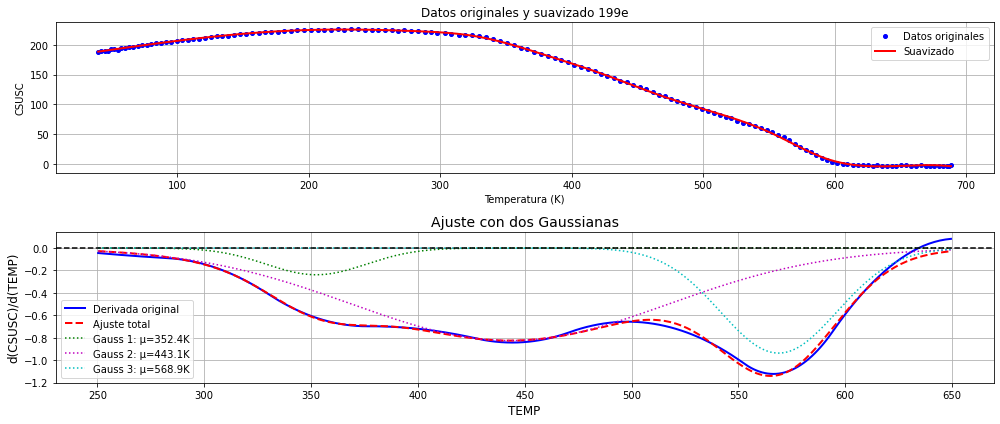


=== Resultados del análisis ===
Gaussiana 1: Amplitud = -0.239, Media μ = 352.4 K, Desviación estándar σ = 23.4 K
Gaussiana 2: Amplitud = -0.825, Media μ = 443.1 K, Desviación estándar σ = -74.1 K
Gaussiana 3: Amplitud = -0.937, Media μ = 568.9 K, Desviación estándar σ = 27.3 K


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# =============================================
# 0. Carga y preparación de datos
# =============================================
try:
    data = np.loadtxt('199e.txt', skiprows=1)
    temp = data[:, 0]
    csusc = data[:, 1]
    
    # Ordenar los datos por temperatura
    sort_idx = np.argsort(temp)
    temp_sorted = temp[sort_idx]
    csusc_sorted = csusc[sort_idx]
    
except Exception as e:
    raise ValueError(f"Error al cargar/ordenar datos: {str(e)}")

# =============================================
# 1. Suavizado y cálculo de derivadas
# =============================================
smoothing_param = 150
spline = UnivariateSpline(temp_sorted, csusc_sorted, s=smoothing_param)
derivative = spline.derivative(n=1)

# Crear malla fina
fine_temp = np.linspace(min(temp_sorted), max(temp_sorted), 500)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Definición de funciones gaussianas
# =============================================
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

def triple_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3):
    return (gaussian(x, amp1, mu1, sigma1) + 
            gaussian(x, amp2, mu2, sigma2) +
            gaussian(x, amp3, mu3, sigma3))

# =============================================
# 3. Ajuste con tres gaussianas (250-650K)
# =============================================
mask = (fine_temp >= 250) & (fine_temp <= 650)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]

# Estimación inicial para tres gaussianas
initial_guess = [-0.5, 400, 30, 
                 0.3, 550, 40,
                 -0.2, 500, 25]  # Nueva gaussiana centrada alrededor de 500K

try:
    popt, pcov = curve_fit(triple_gaussian, x_fit, y_fit, p0=initial_guess)
    amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3 = popt
except RuntimeError as e:
    print(f"Error en ajuste: {e}")
    # Intentar con valores alternativos
    alt_guess = [-0.3, 420, 25, 
                 0.2, 580, 35,
                 -0.1, 480, 20]
    popt, pcov = curve_fit(triple_gaussian, x_fit, y_fit, p0=alt_guess, maxfev=5000)
    amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3 = popt

# =============================================
# 4. Visualización (solo gráficos 1 y 3)
# =============================================
plt.figure(figsize=(14, 6))

# Gráfico 1: Datos originales y suavizado
plt.subplot(2, 1, 1)
plt.plot(temp_sorted, csusc_sorted, 'bo', markersize=4, label='Datos originales')
plt.plot(fine_temp, fine_csusc, 'r-', label='Suavizado', linewidth=2)
plt.xlabel('Temperatura (K)')
plt.ylabel('CSUSC')
plt.title('Datos originales y suavizado 199e')
plt.legend()
plt.grid(True)

# Gráfico 3: Ajuste con gaussianas
plt.subplot(2, 1, 2)
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, triple_gaussian(x_fit, *popt), 'r--', label='Ajuste total', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gauss 1: μ={mu1:.1f}K', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gauss 2: μ={mu2:.1f}K', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp3, mu3, sigma3), 'c:', 
         label=f'Gauss 3: μ={mu3:.1f}K', linewidth=1.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('TEMP', fontsize=12)
plt.ylabel('d(CSUSC)/d(TEMP)', fontsize=12)
plt.title('Ajuste con dos Gaussianas', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 5. Resultados numéricos
# =============================================
print("\n=== Resultados del análisis ===")
print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.1f} K, Desviación estándar σ = {sigma1:.1f} K")
print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.1f} K, Desviación estándar σ = {sigma2:.1f} K")
print(f"Gaussiana 3: Amplitud = {amp3:.3f}, Media μ = {mu3:.1f} K, Desviación estándar σ = {sigma3:.1f} K")

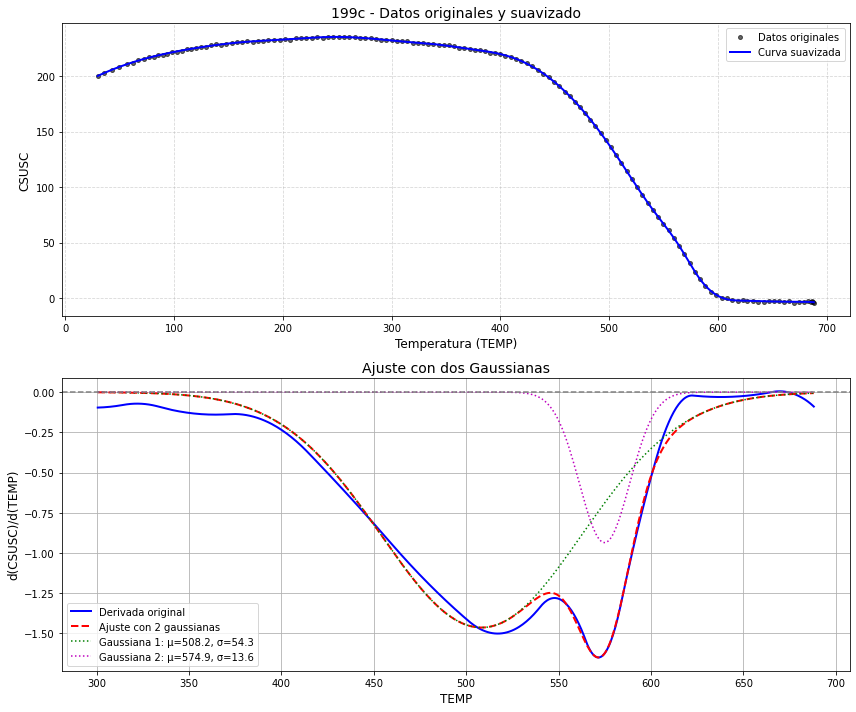


Ajuste controlado:
Gaussiana 1: Amplitud = -1.463, Media μ = 508.218, Desviación estándar σ = -54.309
Gaussiana 2: Amplitud = -0.935, Media μ = 574.855, Desviación estántar σ = 13.612


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('199c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# Configuración común
smoothing_param = 22
fine_temp = np.linspace(min(temp), max(temp), 1000)

# =============================================
# 1. Crear spline y derivada
# =============================================
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Configurar figura con 2 gráficas
# =============================================
plt.figure(figsize=(12, 10))

# ------------------------------------------
# Gráfica 1: Datos originales y suavizado
# ------------------------------------------
plt.subplot(2, 1, 1)
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('199c - Datos originales y suavizado', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# ------------------------------------------
# Gráfica 2: Ajuste con dos gaussianas
# ------------------------------------------
plt.subplot(2, 1, 2)

# Definir funciones gaussianas
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2/(2*sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return gaussian(x, amp1, mu1, sigma1) + gaussian(x, amp2, mu2, sigma2)

# Configurar ajuste
mask = (fine_temp >= 300) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]
initial_guess = [-0.99, 400, 30, 0.7, 550, 40]

# Realizar ajuste
popt, _ = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

# Graficar resultados
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP', fontsize=12)
plt.ylabel('d(CSUSC)/d(TEMP)', fontsize=12)
plt.title('Ajuste con dos Gaussianas', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 3. Función de ajuste controlado (opcional)
# =============================================
def controlled_gaussian_fit(x_data, y_data, mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess, amp1_guess=None, amp2_guess=None):
    """Ajuste con control de parámetros iniciales"""
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    return popt

# Ejecutar ajuste controlado
if __name__ == "__main__":
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=400, sigma1_guess=30,
                                       mu2_guess=550, sigma2_guess=40)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    
    print("\nAjuste controlado:")
    print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.3f}, Desviación estándar σ = {sigma1:.3f}")
    print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.3f}, Desviación estántar σ = {sigma2:.3f}")

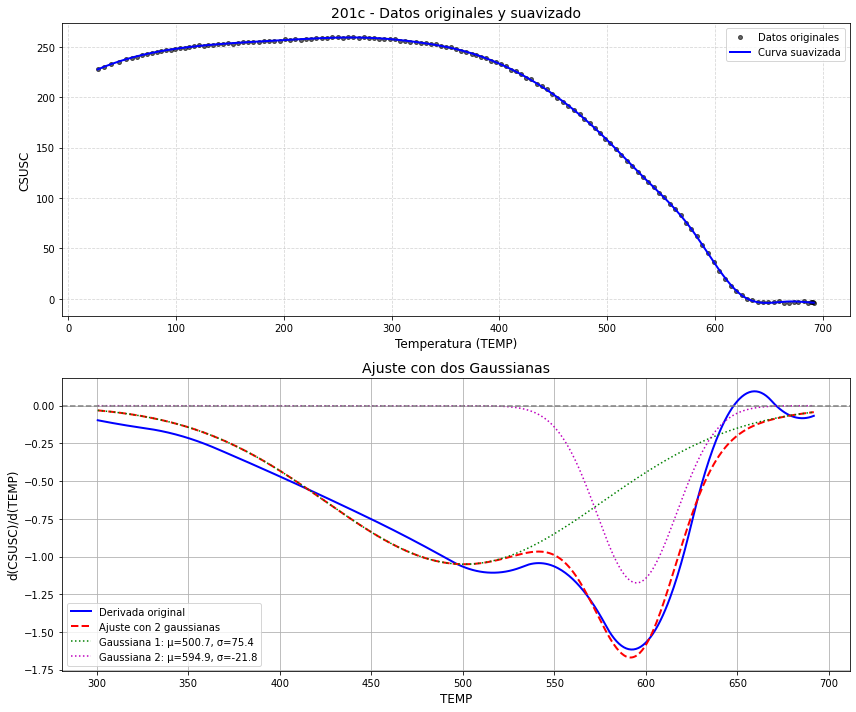


Ajuste controlado:
Gaussiana 1: Amplitud = -1.051, Media μ = 500.728, Desviación estándar σ = -75.423
Gaussiana 2: Amplitud = -1.175, Media μ = 594.942, Desviación estándar σ = 21.848


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('201c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# Configuración común
smoothing_param = 35
fine_temp = np.linspace(min(temp), max(temp), 1000)

# =============================================
# 1. Crear spline y derivada
# =============================================
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Configurar figura con 2 gráficas
# =============================================
plt.figure(figsize=(12, 10))

# ------------------------------------------
# Gráfica 1: Datos originales y suavizado
# ------------------------------------------
plt.subplot(2, 1, 1)
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('201c - Datos originales y suavizado', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# ------------------------------------------
# Gráfica 2: Ajuste con dos gaussianas
# ------------------------------------------
plt.subplot(2, 1, 2)

# Definir funciones gaussianas
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2/(2*sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return gaussian(x, amp1, mu1, sigma1) + gaussian(x, amp2, mu2, sigma2)

# Configurar ajuste
mask = (fine_temp >= 300) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]
initial_guess = [-0.99, 400, 30, 0.7, 550, 40]

# Realizar ajuste
popt, _ = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

# Graficar resultados
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP', fontsize=12)
plt.ylabel('d(CSUSC)/d(TEMP)', fontsize=12)
plt.title('Ajuste con dos Gaussianas', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 3. Función de ajuste controlado (opcional)
# =============================================
def controlled_gaussian_fit(x_data, y_data, mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess, amp1_guess=None, amp2_guess=None):
    """Ajuste con control de parámetros iniciales"""
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    return popt

# Ejecutar ajuste controlado
if __name__ == "__main__":
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=400, sigma1_guess=30,
                                       mu2_guess=550, sigma2_guess=40)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    
    print("\nAjuste controlado:")
    print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.3f}, Desviación estándar σ = {sigma1:.3f}")
    print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.3f}, Desviación estándar σ = {sigma2:.3f}")

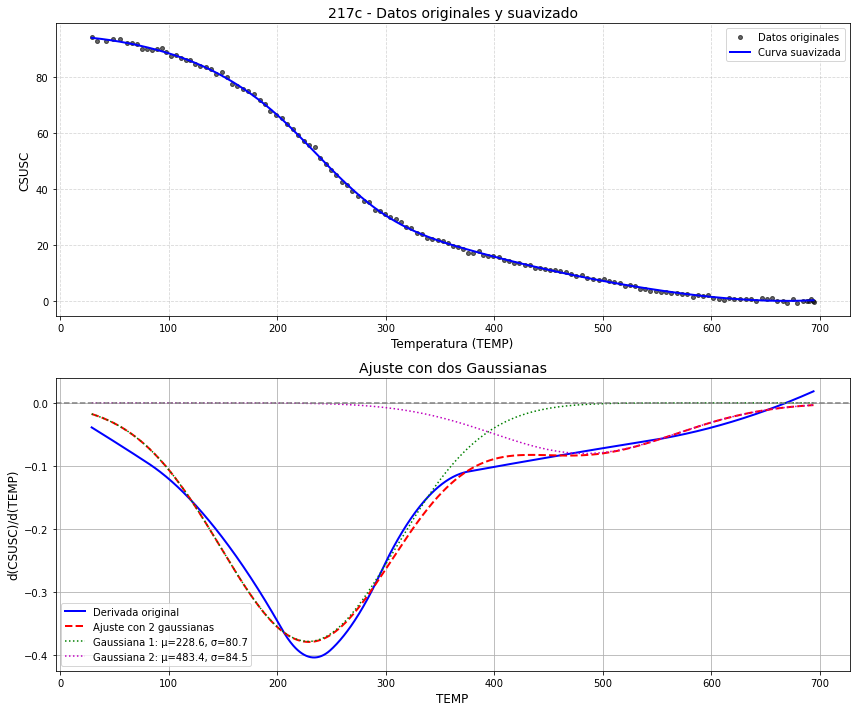


Ajuste controlado:
Gaussiana 1: Amplitud = -0.378, Media μ = 228.591, Desviación estándar σ = 80.695
Gaussiana 2: Amplitud = -0.080, Media μ = 483.387, Desviación estándar σ = 84.513


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# Cargar datos
data = np.loadtxt('217c.txt', skiprows=1)
temp = data[:, 0]
csusc = data[:, 1]

# Configuración común
smoothing_param = 35
fine_temp = np.linspace(min(temp), max(temp), 1000)

# =============================================
# 1. Crear spline y derivada
# =============================================
spline = UnivariateSpline(temp, csusc, s=smoothing_param)
derivative = spline.derivative(n=1)
fine_csusc = spline(fine_temp)
fine_derivative = derivative(fine_temp)

# =============================================
# 2. Configurar figura con 2 gráficas
# =============================================
plt.figure(figsize=(12, 10))

# ------------------------------------------
# Gráfica 1: Datos originales y suavizado
# ------------------------------------------
plt.subplot(2, 1, 1)
plt.plot(temp, csusc, 'ko', markersize=4, label='Datos originales', alpha=0.6)
plt.plot(fine_temp, fine_csusc, 'b-', linewidth=2, label='Curva suavizada')
plt.xlabel('Temperatura (TEMP)', fontsize=12)
plt.ylabel('CSUSC', fontsize=12)
plt.title('217c - Datos originales y suavizado', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# ------------------------------------------
# Gráfica 2: Ajuste con dos gaussianas
# ------------------------------------------
plt.subplot(2, 1, 2)

# Definir funciones gaussianas
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2/(2*sigma**2))

def double_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return gaussian(x, amp1, mu1, sigma1) + gaussian(x, amp2, mu2, sigma2)

# Configurar ajuste
mask = (fine_temp >= 0) & (fine_temp <= 700)
x_fit = fine_temp[mask]
y_fit = fine_derivative[mask]
initial_guess = [-0.99, 400, 30, 0.7, 550, 40]

# Realizar ajuste
popt, _ = curve_fit(double_gaussian, x_fit, y_fit, p0=initial_guess)
amp1, mu1, sigma1, amp2, mu2, sigma2 = popt

# Graficar resultados
plt.plot(x_fit, y_fit, 'b-', label='Derivada original', linewidth=2)
plt.plot(x_fit, double_gaussian(x_fit, *popt), 'r--', 
         label='Ajuste con 2 gaussianas', linewidth=2)
plt.plot(x_fit, gaussian(x_fit, amp1, mu1, sigma1), 'g:', 
         label=f'Gaussiana 1: μ={mu1:.1f}, σ={sigma1:.1f}', linewidth=1.5)
plt.plot(x_fit, gaussian(x_fit, amp2, mu2, sigma2), 'm:', 
         label=f'Gaussiana 2: μ={mu2:.1f}, σ={sigma2:.1f}', linewidth=1.5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('TEMP', fontsize=12)
plt.ylabel('d(CSUSC)/d(TEMP)', fontsize=12)
plt.title('Ajuste con dos Gaussianas', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# 3. Función de ajuste controlado (opcional)
# =============================================
def controlled_gaussian_fit(x_data, y_data, mu1_guess, sigma1_guess, 
                          mu2_guess, sigma2_guess, amp1_guess=None, amp2_guess=None):
    """Ajuste con control de parámetros iniciales"""
    if amp1_guess is None:
        amp1_guess = np.min(y_data) if mu1_guess > np.mean(x_data) else np.max(y_data)
    if amp2_guess is None:
        amp2_guess = np.min(y_data) if mu2_guess > np.mean(x_data) else np.max(y_data)
    
    initial = [amp1_guess, mu1_guess, sigma1_guess, 
               amp2_guess, mu2_guess, sigma2_guess]
    
    popt, _ = curve_fit(double_gaussian, x_data, y_data, p0=initial)
    return popt

# Ejecutar ajuste controlado
if __name__ == "__main__":
    custom_fit = controlled_gaussian_fit(x_fit, y_fit,
                                       mu1_guess=400, sigma1_guess=30,
                                       mu2_guess=550, sigma2_guess=40)
    amp1, mu1, sigma1, amp2, mu2, sigma2 = custom_fit
    
    print("\nAjuste controlado:")
    print(f"Gaussiana 1: Amplitud = {amp1:.3f}, Media μ = {mu1:.3f}, Desviación estándar σ = {sigma1:.3f}")
    print(f"Gaussiana 2: Amplitud = {amp2:.3f}, Media μ = {mu2:.3f}, Desviación estándar σ = {sigma2:.3f}")